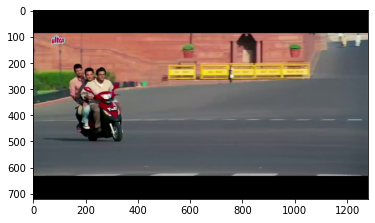

In [1]:
# import 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# read video
cap = cv2.VideoCapture('../../data/Videos/3idiots.mp4')

# read first frame
ret, frame = cap.read()

# convert to rgb
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# display the first frame
plt.imshow(frame)
plt.show()


In [2]:
input_size = 512
frame_size = frame.shape[:2]
image_data = cv2.resize(frame, (input_size, input_size))
image_data = image_data / 255.
image_data = image_data[np.newaxis, ...].astype(np.float32)

batch_data = tf.constant(image_data)

In [3]:
infer_rider_motor = keras.models.load_model('../../Weights/rider_motor_512')
rider_motor_bbox = infer_rider_motor.predict(batch_data)

1/1 [==============================] - 37s 37s/step


In [4]:
iou = 0.45
score = 0.50

for value in rider_motor_bbox:
    temp_value = np.expand_dims(value, axis=0)
    R_M_boxes = temp_value[:, :, 0:4]
    pred_conf = temp_value[:, :, 4:]

R_M_boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(R_M_boxes, (tf.shape(R_M_boxes)[0], -1, 1, 4)),
            scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=iou,
            score_threshold=score
        )
num_objects = valid_detections.numpy()[0]
R_M_boxes = R_M_boxes.numpy()[0]
R_M_boxes = R_M_boxes[0:int(num_objects)]
scores = scores.numpy()[0]
scores = scores[0:int(num_objects)]
classes = classes.numpy()[0]
classes = classes[0:int(num_objects)]

deleted_indx = []
allowed_classes = [0,1]
for i in range(num_objects):
    class_indx = int(classes[i])
    if class_indx not in allowed_classes:
        deleted_indx.append(i)
R_M_boxes = np.delete(R_M_boxes, deleted_indx, axis=0)
scores = np.delete(scores, deleted_indx, axis=0)
classes = np.delete(classes, deleted_indx, axis=0)
num_objects = len(classes)

# MOTORCYCLE CLASS CHANGED TO 3 FROM 1
classes[classes == 1] = 3

print("Allowed classes (RM)")
print(classes)

print(R_M_boxes.shape)
print(classes)

Allowed classes (RM)
[3. 0. 0.]
(3, 4)
[3. 0. 0.]


In [5]:
import pandas as pd

# Getting the rider motorcycle dataframe 

# Bounding boxes are in normalized ymin, xmin, ymax, xmax
original_h, original_w, _ = frame.shape

#getting rider, motorcycle dataframe
df = pd.DataFrame(classes, columns=['class_id'])
ymin = R_M_boxes[:, 0]
xmin = R_M_boxes[:, 1]
ymax = R_M_boxes[:, 2]
xmax = R_M_boxes[:, 3]
df['x'] = pd.DataFrame(xmin + (xmax-xmin)/2, columns=['x'])
df['y'] = pd.DataFrame(ymin + (ymax-ymin)/2, columns=['y'])
df['w'] = pd.DataFrame(xmax-xmin, columns=['w'])
df['h'] = pd.DataFrame(ymax-ymin, columns=['h'])
rider = df.loc[df['class_id']==0]
motorcycle = df.loc[df['class_id']==3]

print(rider)
print(motorcycle)

   class_id         x         y         w         h
1       0.0  0.209013  0.479911  0.090316  0.339626
2       0.0  0.158165  0.474923  0.082741  0.336784
   class_id        x         y         w         h
0       3.0  0.20689  0.552647  0.150746  0.301193


In [6]:
# assign instance id to each rider AND motorcycle
import sys
sys.path.append('../')
from core.association import motor_rider_iou, motor2_rider_iou

def get_instance(rider, motorcycle, iou_threshold):
    """
    args:
    rider, motorcycle : pd.DataFrame

    output:
    rider, motorycle : pd.DataFrame with a column named 'instance_id'
    """
    rider['instance_id'] = -1
    motorcycle['instance_id'] = -1
    
    for i in range(len(motorcycle)):
        motorcycle.iat[i,motorcycle.columns.get_loc('instance_id')] = i
        for j in range(len(rider)):
            if (motor_rider_iou(motorcycle.iloc[i], rider.iloc[j]) > iou_threshold):
                if (rider.iloc[j]['instance_id'] == -1):
                    rider.iat[j,rider.columns.get_loc('instance_id')] = i
                else:
                    instance = int(rider.iloc[j]['instance_id'])
                    instance_final = motor2_rider_iou(motorcycle.iloc[i], motorcycle.iloc[instance], rider.iloc[j], i, instance)
                    rider.iat[j,rider.columns.get_loc('instance_id')] = instance_final
    return rider, motorcycle

rider, motorcycle = get_instance(rider, motorcycle, 0.01)
print(rider)
print(motorcycle)


   class_id         x         y         w         h  instance_id
1       0.0  0.209013  0.479911  0.090316  0.339626            0
2       0.0  0.158165  0.474923  0.082741  0.336784            0
   class_id        x         y         w         h  instance_id
0       3.0  0.20689  0.552647  0.150746  0.301193            0


C:\Users\basur\AppData\Local\Temp\ipykernel_15464\4082315931.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider['instance_id'] = -1
C:\Users\basur\AppData\Local\Temp\ipykernel_15464\4082315931.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motorcycle['instance_id'] = -1


<class 'pandas.core.series.Series'>
0    0.282263
dtype: float32
<class 'float'>
(206, 138, 520, 371)


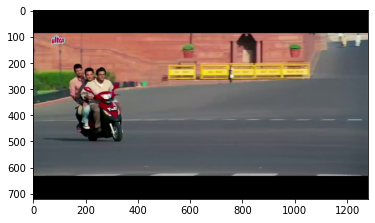

In [7]:
def extract_roi(frame, rider, motorcycle) :
    """
    args:
    frame : np.array
    rider, motorcycle : pd.DataFrame

    output:
    roi_instances : list of np.array
    """
    roi_instances = []
    for i in range(len(motorcycle)):
        motor = motorcycle.loc[motorcycle['instance_id']==i]
        instance = motorcycle.iloc[i]['instance_id']
        ride = rider.loc[rider['instance_id']== instance]

        if (len(ride)==0):
            continue
        
        print(type(motor['x'] + motor['w']/2))
        print(motor['x'] + motor['w']/2)
        print(type(max(ride['x'] + ride['w']/2)))
        xmax = max(float(motor['x'] + motor['w']/2), max(ride['x'] + ride['w']/2))
        xmin = min(float(motor['x'] - motor['w']/2), min(ride['x'] - ride['w']/2))
        ymax = max(float(motor['y'] + motor['h']/2), max(ride['y'] + ride['h']/2))
        ymin = min(float(motor['y'] - motor['h']/2), min(ride['y'] - ride['h']/2))

        w = xmax - xmin
        h = ymax - ymin

        xmax = xmax + 0.05*w
        xmin = xmin - 0.05*w

        ymax = ymax + 0.05 * h
        ymin = ymin - 0.05 * h

        if (xmin < 0):
            xmin=0
        if (xmax >1):
            xmax=1
        if (ymax>1):
            ymax =1
        if(ymin<0):
            ymin =0

        t = int(ymin*frame.shape[0])
        l = int(xmin*frame.shape[1])
        b = int(ymax*frame.shape[0])
        r = int(xmax*frame.shape[1])

        if t<0 or l<0 or b<0 or r<0:
            continue
        # roi_frame = frame[t:b, l:r]
        roi_frame = frame
        original_position = (t,l,b,r)
        roi_dict = {'frame':roi_frame, 'original_position':original_position}
        roi_instances.append(roi_dict)

    return roi_instances

roi_instances = extract_roi(frame, rider, motorcycle)

# display the cropped images
for i in range(len(roi_instances)):
    plt.imshow(roi_instances[i]['frame'])
    print(roi_instances[i]['original_position'])
    plt.show()


In [8]:
input_size = 512
all_batch_data = []
for i in range(len(roi_instances)):
    instance_frame = roi_instances[i]['frame']
    frame_size = instance_frame.shape[:2]
    image_data = cv2.resize(instance_frame, (input_size, input_size))
    image_data = image_data / 255.
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    batch_data = tf.constant(image_data)
    all_batch_data.append(batch_data)

In [9]:
infer_RHNH = keras.models.load_model('../../Weights/helmet_no_helmet_512')
all_instance_H_NH_boxes = []

for i in range(len(all_batch_data)):
    batch_data = all_batch_data[i]
    H_NH_boxes = infer_RHNH.predict(batch_data)
    all_instance_H_NH_boxes.append(H_NH_boxes)

1/1 [==============================] - 38s 38s/step


[2. 2. 2.]


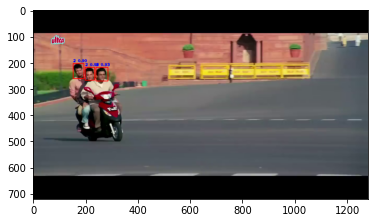

In [13]:
all_final_HNH_boxes = []
all_pred_conf_HNH = []
for i in range(len(all_instance_H_NH_boxes)):
    single_instance_boxes = all_instance_H_NH_boxes[i]
    for value in single_instance_boxes:
        temp_value = np.expand_dims(value, axis=0)
        boxes = temp_value[:, :, 0:4]
        conf = temp_value[:, :, 4:]
    all_final_HNH_boxes.append(boxes)
    all_pred_conf_HNH.append(conf)


# NMS

for i in range(len(all_final_HNH_boxes)):
    boxes = all_final_HNH_boxes[i]
    conf = all_pred_conf_HNH[i]
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(conf, (tf.shape(conf)[0], -1, tf.shape(conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=0.45,
        score_threshold=0.5
    )

    num_objects_HNH = valid_detections.numpy()[0]
    bboxes_HNH = boxes.numpy()[0]
    bboxes_HNH = bboxes_HNH[0:int(num_objects_HNH)]
    scores_HNH = scores.numpy()[0]
    scores_HNH = scores_HNH[0:int(num_objects_HNH)]
    classes_HNH = classes.numpy()[0]
    classes_HNH = classes_HNH[0:int(num_objects_HNH)]

    deleted_indx = []
    allowed_classes = [0, 1]
    for i in range(num_objects_HNH):
        class_indx = int(classes_HNH[i])
        if class_indx not in allowed_classes:
            deleted_indx.append(i)
    bboxes_HNH = np.delete(bboxes_HNH, deleted_indx, axis=0)
    scores_HNH = np.delete(scores_HNH, deleted_indx, axis=0)
    classes_HNH = np.delete(classes_HNH, deleted_indx, axis=0)
    num_objects_HNH = len(classes_HNH)

    classes_HNH[classes_HNH == 1] = 2
    classes_HNH[classes_HNH == 0] = 1

    print(classes_HNH)
    
# show the bounding box and the label on the image
for i in range(len(roi_instances)):
    instance_frame = roi_instances[i]['frame']
    for j in range(num_objects_HNH):
        xmin = int(bboxes_HNH[j][1] * frame_size[1])
        ymin = int(bboxes_HNH[j][0] * frame_size[0])
        xmax = int(bboxes_HNH[j][3] * frame_size[1])
        ymax = int(bboxes_HNH[j][2] * frame_size[0])
        if classes_HNH[j] == 1:
            cv2.rectangle(instance_frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        else :
            cv2.rectangle(instance_frame, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(instance_frame, '{} {:.2f}'.format(int(classes_HNH[j]), scores_HNH[j]),
                    (xmin, ymin - 5), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
    plt.imshow(instance_frame)
    plt.show()
